**Made By -**

1. **Divyansh Sharma (2019A4PS0753G)**
2. **Priyansh Bhavesh Parikh (2019A3PS0288G)**
3. **Taresh Batra (2019A3PS0388G)** 

#**Introduction**

We have examined the role of skip-connections in moderately deep MLP models (5-6 layers) for the task of image classification. 4 Types of neural networks have been dealt with in this assignment, their names are as follows:

1. **No Skip Connection Network (Vanilla Net)**

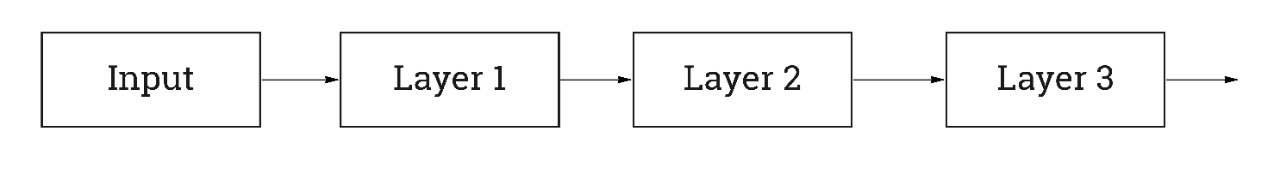

2. **Distinct-Source Skip Connection Network (1 and 2 layers skipped)**

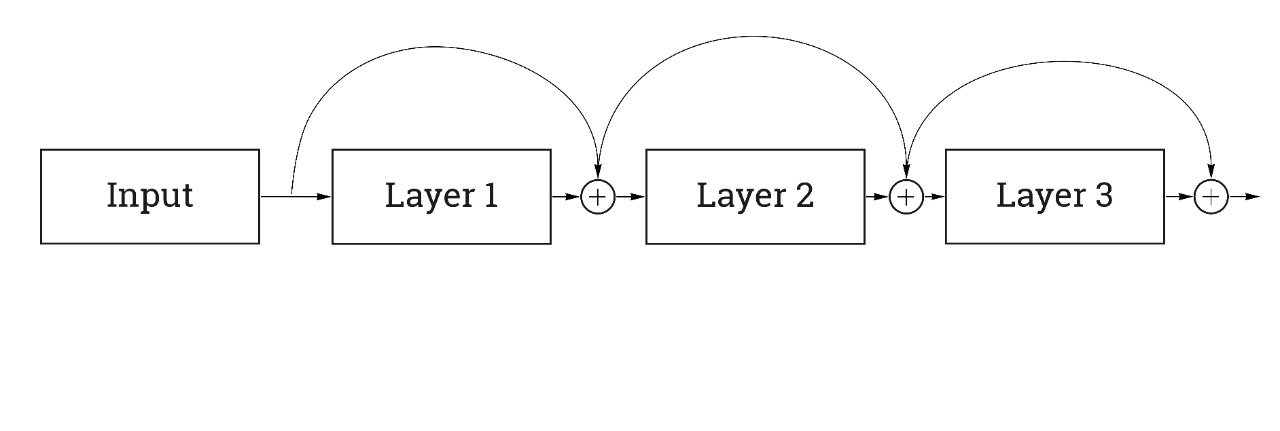


3. **Shared-Source Skip Connection Network**

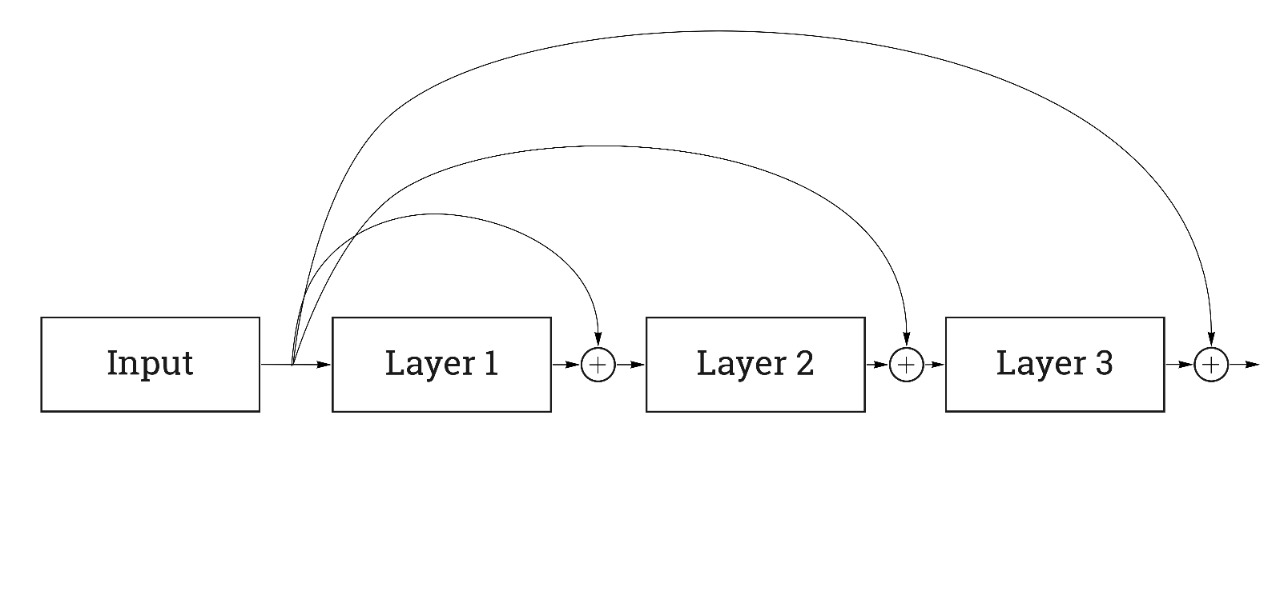



4. **Dense Skip Connection Network**

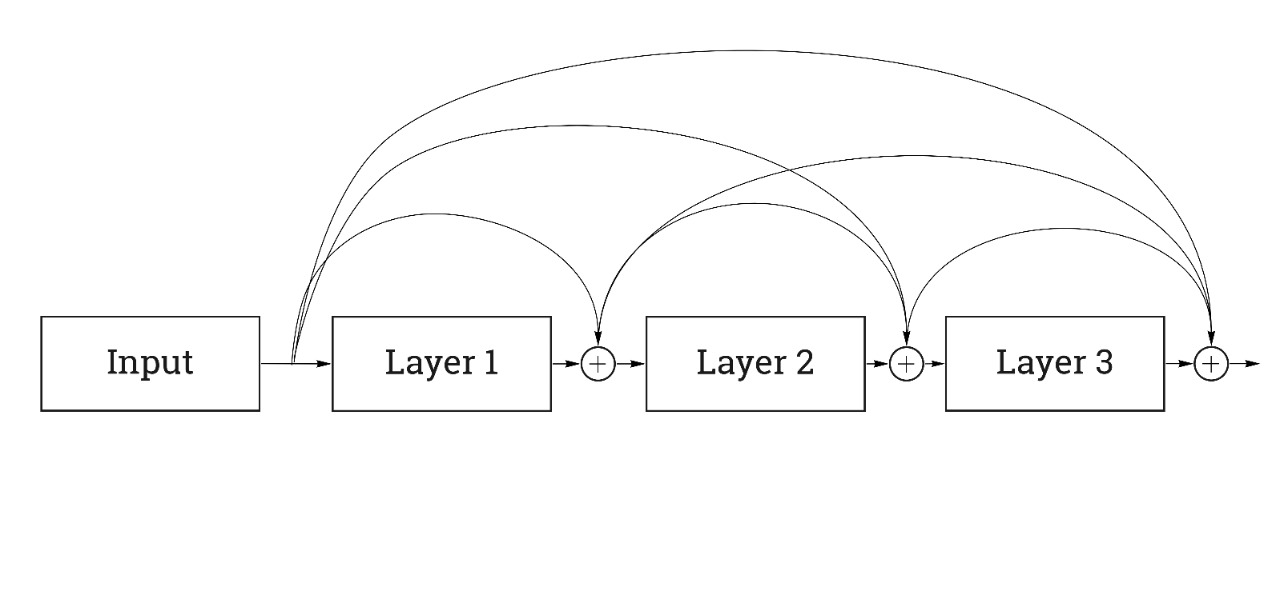



2 variants of these networks were developed in order to train on the MNIST and CIFAR-10 datasets. These networks have ADAM as the optimizer, cross entropy as the loss function and batch normalization has been applied across all the layers. Regularization techniques haven't been used.

**Note:** Since the models have progressively decreaing layers (in terms of dimensions), we have used weight matrices to transform the dimenions as per the requirement in skip conenctions.



#**Imports**

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#**Standard Parameters**

In [ ]:
batch_size = 64
epochs_mnist = 10
epochs_cifar10 = 15
lr = 0.001
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
criterion = nn.CrossEntropyLoss()

#**Loading the Datasets**

**MNIST**

In [ ]:
def load_mnist_data(data_dir = "./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset_mnist = torchvision.datasets.MNIST(
        root=data_dir, train=True, download=True, transform=transform)
    
    testset_mnist = torchvision.datasets.MNIST(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset_mnist, testset_mnist

trainset_mnist, testset_mnist = load_mnist_data()

trainset_mnist, validset_mnist = torch.utils.data.random_split(trainset_mnist, [50000, 10000])

trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader_mnist = torch.utils.data.DataLoader(validset_mnist, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**CIFAR 10**

In [ ]:
def load_cifar10_data(data_dir = "./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset_cifar10 = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)
    
    testset_cifar10 = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset_cifar10, testset_cifar10

trainset_cifar10, testset_cifar10 = load_cifar10_data()

trainset_cifar10, validset_cifar10 = torch.utils.data.random_split(trainset_cifar10, [40000, 10000])

trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader_cifar10 = torch.utils.data.DataLoader(validset_cifar10, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#**Analysis on the MNIST Dataset**

## **Defining a Vanilla Neural Network (without skip connections)**


In [ ]:
class vanilla_net_mnist(nn.Module):

  def __init__(self):
        super().__init__()

        dimensions = {}
        dimensions['Layer 1'] = 256
        dimensions['Layer 2'] = 128
        dimensions['Layer 3'] = 64
        dimensions['Layer 4'] = 32
        dimensions['Layer 5'] = 10  # number of classes in MNIST data

        self.l1 = nn.Linear(28*28, dimensions['Layer 1'])
        self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
        self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
        self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
        self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])
        
        self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
        self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
        self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
        self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])

  def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dims except batch
        x = F.relu(self.bn1(self.l1(x)))
        x = F.relu(self.bn2(self.l2(x)))
        x = F.relu(self.bn3(self.l3(x)))
        x = F.relu(self.bn4(self.l4(x)))
        x = self.l5(x)
        return x

vanilla_model_mnist = vanilla_net_mnist().to(device)

##**Defining a Series of Distinct-Source Skip Connection Neural Networks**

The parameter being varied here is the number of layers skipped. We have experimented with this number being 1 and 2, i.e., 1 and 2 layers skipped. The two models are named as distinct_source_skip_net_n_mnist, where n refers to the number of layers skipped.



###**Distinct-Source Skip Net With 1 Layer Skipped**

In [ ]:
class distinct_source_skip_net_1_mnist(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 256
      dimensions['Layer 2'] = 128
      dimensions['Layer 3'] = 64
      dimensions['Layer 4'] = 32
      dimensions['Layer 5'] = 10  # number of classes in MNIST data

      self.l1 = nn.Linear(28*28, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])

      self.skip_input_2 = nn.Linear(28*28, dimensions['Layer 2'])
      self.skip_1_3 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 3'])
      self.skip_2_4 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 4'])
      self.skip_3_5 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 5'])

      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1) + self.skip_input_2(x0)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_1_3(x1)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_2_4(x2)))
      x5 = self.l5(x4) + self.skip_3_5(x3)

      return x5


dictinct_source_skip_1_model_mnist = distinct_source_skip_net_1_mnist().to(device)

###**Distinct-Source Skip Net With 2 Layers Skipped**

In [ ]:
class distinct_source_skip_net_2_mnist(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 256
      dimensions['Layer 2'] = 128
      dimensions['Layer 3'] = 64
      dimensions['Layer 4'] = 32
      dimensions['Layer 5'] = 10  # number of classes in MNIST data

      self.l1 = nn.Linear(28*28, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])

      self.skip_input_3 = nn.Linear(28*28, dimensions['Layer 3'])
      self.skip_1_4 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 4'])
      self.skip_2_5 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 5'])

      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4']) 

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_input_3(x0)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_1_4(x1)))
      x5 = self.l5(x4) + self.skip_2_5(x2)
      return x5


dictinct_source_skip_2_model_mnist = distinct_source_skip_net_2_mnist().to(device)

##**Defining a Shared-Source Skip Connection Neural Network**

In [ ]:
class shared_source_skip_net_mnist(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 256
      dimensions['Layer 2'] = 128
      dimensions['Layer 3'] = 64
      dimensions['Layer 4'] = 32
      dimensions['Layer 5'] = 10  # number of classes in MNIST data

      self.l1 = nn.Linear(28*28, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])

      self.skip_input_2 = nn.Linear(28*28, dimensions['Layer 2'])
      self.skip_input_3 = nn.Linear(28*28, dimensions['Layer 3'])
      self.skip_input_4 = nn.Linear(28*28, dimensions['Layer 4'])
      self.skip_input_5 = nn.Linear(28*28, dimensions['Layer 5'])

      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1) + self.skip_input_2(x0)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_input_3(x0)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_input_4(x0)))
      x5 = self.l5(x4) + self.skip_input_5(x0)
      return x5


shared_source_skip_model_mnist = shared_source_skip_net_mnist().to(device)

##**Defining a Dense Skip Connection Neural Network**

In [ ]:
class dense_skip_net_mnist(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 256
      dimensions['Layer 2'] = 128
      dimensions['Layer 3'] = 64
      dimensions['Layer 4'] = 32
      dimensions['Layer 5'] = 10  # number of classes in MNIST data

      self.l1 = nn.Linear(28*28, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])

      # from input
      self.skip_input_2 = nn.Linear(28*28, dimensions['Layer 2'])
      self.skip_input_3 = nn.Linear(28*28, dimensions['Layer 3'])
      self.skip_input_4 = nn.Linear(28*28, dimensions['Layer 4'])
      self.skip_input_5 = nn.Linear(28*28, dimensions['Layer 5'])

      # from layer 1
      self.skip_1_3 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 3'])
      self.skip_1_4 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 4'])
      self.skip_1_5 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 5'])
      
      # from layer 2
      self.skip_2_4 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 4'])
      self.skip_2_5 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 5'])

      # from layer 3
      self.skip_3_5 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 5'])

      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1) + self.skip_input_2(x0)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_input_3(x0) + self.skip_1_3(x1)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_input_4(x0) + self.skip_1_4(x1) + self.skip_2_4(x2)))
      x5 = self.l5(x4) + self.skip_input_5(x0) + self.skip_1_5(x1) + self.skip_2_5(x2) + self.skip_3_5(x3)
      return x5


dense_skip_model_mnist = dense_skip_net_mnist().to(device)

##**Training the Models**

**Defining the Training Function**

In [ ]:
def train_mnist(model):

  # defining the optimizer
  optimizer = optim.Adam(model.parameters(), lr=lr)
  best_model = model
  min_valid_loss = math.inf
  training_loss_list = []
  validation_loss_list = []

  for epoch in range(epochs_mnist):
    running_loss = 0.0
    train_loss = 0.0
    epoch_steps = 0

    for i, data in enumerate(trainloader_mnist, 0):
          
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          train_loss += loss.item()
          epoch_steps += 1
          if i % 500 == 499:  # print every 500 mini-batches
              print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                              running_loss / epoch_steps))
              running_loss = 0.0
  
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0

    # finding the generalization error
    for i, data in enumerate(validloader_mnist, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            val_loss += loss.cpu().numpy()
            val_steps += 1

    # to get the model with the least generalization error
    if (val_loss <= min_valid_loss):
      best_model = model
      min_valid_loss = val_loss

    training_loss_list.append(train_loss/len(trainloader_mnist))
    validation_loss_list.append(val_loss/len(validloader_mnist))

    print(f"Epoch {epoch+1} training loss = {train_loss/len(trainloader_mnist):.2f} validation loss: {val_loss/len(validloader_mnist):.2f}")

  model = best_model

  # plotting the training process
  plt.plot(training_loss_list, 'r', label = 'Training Loss')
  plt.plot(validation_loss_list, 'g', label = 'Validation Loss')
  plt.legend()
  plt.show()

**Training vanilla_model_mnist**

[1,   500] loss: 0.434
Epoch 1 training loss = 0.34 validation loss: 0.16
[2,   500] loss: 0.111
Epoch 2 training loss = 0.11 validation loss: 0.12
[3,   500] loss: 0.077
Epoch 3 training loss = 0.08 validation loss: 0.10
[4,   500] loss: 0.058
Epoch 4 training loss = 0.06 validation loss: 0.10
[5,   500] loss: 0.050
Epoch 5 training loss = 0.05 validation loss: 0.10
[6,   500] loss: 0.045
Epoch 6 training loss = 0.05 validation loss: 0.10
[7,   500] loss: 0.035
Epoch 7 training loss = 0.04 validation loss: 0.10
[8,   500] loss: 0.031
Epoch 8 training loss = 0.03 validation loss: 0.09
[9,   500] loss: 0.030
Epoch 9 training loss = 0.03 validation loss: 0.09
[10,   500] loss: 0.027
Epoch 10 training loss = 0.03 validation loss: 0.09


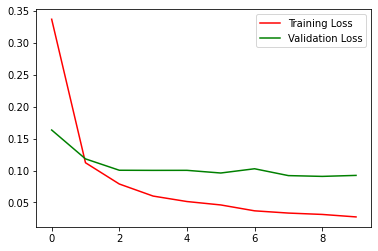

In [ ]:
train_mnist(vanilla_model_mnist)

**Training dictinct_source_skip_1_model_mnist**

[1,   500] loss: 0.274
Epoch 1 training loss = 0.22 validation loss: 0.13
[2,   500] loss: 0.092
Epoch 2 training loss = 0.09 validation loss: 0.11
[3,   500] loss: 0.061
Epoch 3 training loss = 0.06 validation loss: 0.09
[4,   500] loss: 0.049
Epoch 4 training loss = 0.05 validation loss: 0.08
[5,   500] loss: 0.037
Epoch 5 training loss = 0.04 validation loss: 0.10
[6,   500] loss: 0.032
Epoch 6 training loss = 0.03 validation loss: 0.09
[7,   500] loss: 0.025
Epoch 7 training loss = 0.03 validation loss: 0.09
[8,   500] loss: 0.023
Epoch 8 training loss = 0.02 validation loss: 0.09
[9,   500] loss: 0.018
Epoch 9 training loss = 0.02 validation loss: 0.08
[10,   500] loss: 0.018
Epoch 10 training loss = 0.02 validation loss: 0.09


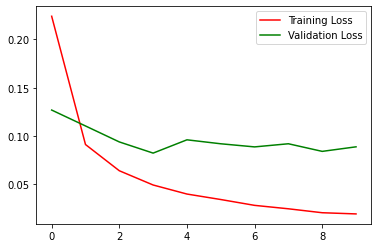

In [ ]:
train_mnist(dictinct_source_skip_1_model_mnist)

**Training dictinct_source_skip_2_model_mnist**

[1,   500] loss: 0.252
Epoch 1 training loss = 0.21 validation loss: 0.12
[2,   500] loss: 0.088
Epoch 2 training loss = 0.09 validation loss: 0.10
[3,   500] loss: 0.060
Epoch 3 training loss = 0.06 validation loss: 0.10
[4,   500] loss: 0.043
Epoch 4 training loss = 0.05 validation loss: 0.10
[5,   500] loss: 0.030
Epoch 5 training loss = 0.04 validation loss: 0.09
[6,   500] loss: 0.030
Epoch 6 training loss = 0.03 validation loss: 0.09
[7,   500] loss: 0.024
Epoch 7 training loss = 0.03 validation loss: 0.08
[8,   500] loss: 0.020
Epoch 8 training loss = 0.02 validation loss: 0.09
[9,   500] loss: 0.018
Epoch 9 training loss = 0.02 validation loss: 0.09
[10,   500] loss: 0.017
Epoch 10 training loss = 0.02 validation loss: 0.09


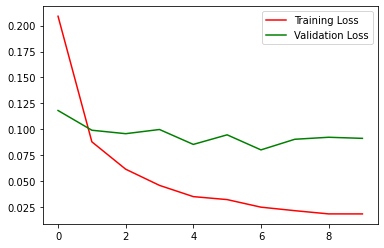

In [ ]:
train_mnist(dictinct_source_skip_2_model_mnist)

**Training shared_source_skip_model_mnist**

[1,   500] loss: 0.322
Epoch 1 training loss = 0.26 validation loss: 0.14
[2,   500] loss: 0.104
Epoch 2 training loss = 0.10 validation loss: 0.10
[3,   500] loss: 0.067
Epoch 3 training loss = 0.07 validation loss: 0.11
[4,   500] loss: 0.049
Epoch 4 training loss = 0.05 validation loss: 0.11
[5,   500] loss: 0.038
Epoch 5 training loss = 0.04 validation loss: 0.10
[6,   500] loss: 0.031
Epoch 6 training loss = 0.03 validation loss: 0.10
[7,   500] loss: 0.029
Epoch 7 training loss = 0.03 validation loss: 0.10
[8,   500] loss: 0.025
Epoch 8 training loss = 0.03 validation loss: 0.10
[9,   500] loss: 0.023
Epoch 9 training loss = 0.02 validation loss: 0.09
[10,   500] loss: 0.013
Epoch 10 training loss = 0.02 validation loss: 0.10


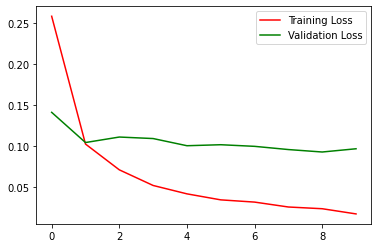

In [ ]:
train_mnist(shared_source_skip_model_mnist)

**Training dense_skip_model_mnist**

[1,   500] loss: 0.222
Epoch 1 training loss = 0.19 validation loss: 0.13
[2,   500] loss: 0.088
Epoch 2 training loss = 0.09 validation loss: 0.11
[3,   500] loss: 0.056
Epoch 3 training loss = 0.06 validation loss: 0.09
[4,   500] loss: 0.044
Epoch 4 training loss = 0.04 validation loss: 0.10
[5,   500] loss: 0.032
Epoch 5 training loss = 0.03 validation loss: 0.08
[6,   500] loss: 0.029
Epoch 6 training loss = 0.03 validation loss: 0.09
[7,   500] loss: 0.022
Epoch 7 training loss = 0.02 validation loss: 0.09
[8,   500] loss: 0.015
Epoch 8 training loss = 0.02 validation loss: 0.10
[9,   500] loss: 0.015
Epoch 9 training loss = 0.02 validation loss: 0.10
[10,   500] loss: 0.015
Epoch 10 training loss = 0.02 validation loss: 0.11


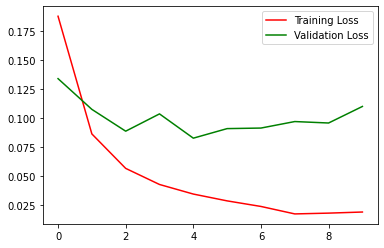

In [ ]:
train_mnist(dense_skip_model_mnist)

##**Testing the Models**

**Defining the Test Function**

In [ ]:
def test_mnist(model):
  model.eval()

  total = 0
  correct = 0
  val_loss = 0.0
  val_steps = 0
  for inputs, labels in testloader_mnist:
    with torch.no_grad():
      if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_steps += 1
        
  print("Accuracy = ", correct/total)

**Testing vanilla_model_mnist**

In [ ]:
test_mnist(vanilla_model_mnist)

Accuracy =  0.9814


**Testing dictinct_source_skip_1_model_mnist**

In [ ]:
test_mnist(dictinct_source_skip_1_model_mnist)

Accuracy =  0.98


**Testing dictinct_source_skip_2_model_mnist**

In [ ]:
test_mnist(dictinct_source_skip_2_model_mnist)

Accuracy =  0.9803


**Testing shared_source_skip_model_mnist**

In [ ]:
test_mnist(shared_source_skip_model_mnist)

Accuracy =  0.9779


**Traing dense_skip_model_mnist**

In [ ]:
test_mnist(dense_skip_model_mnist)

Accuracy =  0.9778


##**Interpreting the Results on MNIST**

It seems like skip connections do not help the performance of the vanilla MLP. The accuracies of all networks are similar on the testset. These accuracies vary slightly depending on the training-validation split. Thus, we did not see it fit to rank these networks based on their accuracies.

Therefore, the results lead us to believe that skip connections do not help improve shallow MLPs on image classification tasks (atleast).

#**Analysis on the CIFAR 10 Dataset**

## **Defining a Vanilla Neural Network (without skip connections)**

In [ ]:
class vanilla_net_cifar10(nn.Module):

  def __init__(self):
        super().__init__()

        dimensions = {}
        dimensions['Layer 1'] = 512
        dimensions['Layer 2'] = 256
        dimensions['Layer 3'] = 128
        dimensions['Layer 4'] = 64
        dimensions['Layer 5'] = 32  
        dimensions['Layer 6'] = 10 # number of classes in CIFAR 10 data

        self.l1 = nn.Linear(32*32*3, dimensions['Layer 1'])
        self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
        self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
        self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
        self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])
        self.l6 = nn.Linear(dimensions['Layer 5'], dimensions['Layer 6'])

        self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
        self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
        self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
        self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])
        self.bn5 = nn.BatchNorm1d(dimensions['Layer 5'])

  def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dims except batch
        x = F.relu(self.bn1(self.l1(x)))
        x = F.relu(self.bn2(self.l2(x)))
        x = F.relu(self.bn3(self.l3(x)))
        x = F.relu(self.bn4(self.l4(x)))
        x = F.relu(self.bn5(self.l5(x)))
        x = self.l6(x)
        return x

vanilla_model_cifar10 = vanilla_net_cifar10().to(device)

##**Defining a Series of Distinct-Source Skip Connection Neural Networks**

The parameter being varied here is the number of layers skipped. We have experimented with this number being 1 and 2, i.e., 1 and 2 layers skipped. The two models are named as distinct_source_skip_net_n_cifar10, where n refers to the number of layers skipped.

###**Distinct-Source Skip Net With 1 Layer Skipped**

In [ ]:
class distinct_source_skip_net_1_cifar10(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 512
      dimensions['Layer 2'] = 256
      dimensions['Layer 3'] = 128
      dimensions['Layer 4'] = 64
      dimensions['Layer 5'] = 32  
      dimensions['Layer 6'] = 10 # number of classes in CIFAR 10 data

      self.l1 = nn.Linear(32*32*3, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])
      self.l6 = nn.Linear(dimensions['Layer 5'], dimensions['Layer 6'])
              

      self.skip_input_2 = nn.Linear(32*32*3, dimensions['Layer 2'])
      self.skip_1_3 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 3'])
      self.skip_2_4 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 4'])
      self.skip_3_5 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 5'])
      self.skip_4_6 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 6'])
        
      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])
      self.bn5 = nn.BatchNorm1d(dimensions['Layer 5'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1) + self.skip_input_2(x0)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_1_3(x1)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_2_4(x2)))
      x5 = F.relu(self.bn5(self.l5(x4) + self.skip_3_5(x3)))
      x6 = self.l6(x5) + self.skip_4_6(x4)
      return x6


dictinct_source_skip_1_model_cifar10 = distinct_source_skip_net_1_cifar10().to(device)

###**Distinct-Source Skip Net With 2 Layers Skipped**

In [ ]:
class distinct_source_skip_net_2_cifar10(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 512
      dimensions['Layer 2'] = 256
      dimensions['Layer 3'] = 128
      dimensions['Layer 4'] = 64
      dimensions['Layer 5'] = 32  
      dimensions['Layer 6'] = 10 # number of classes in CIFAR 10 data

      self.l1 = nn.Linear(32*32*3, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])
      self.l6 = nn.Linear(dimensions['Layer 5'], dimensions['Layer 6'])
      
      self.skip_input_3 = nn.Linear(32*32*3, dimensions['Layer 3'])
      self.skip_1_4 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 4'])
      self.skip_2_5 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 5'])
      self.skip_3_6 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 6'])
      
      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])
      self.bn5 = nn.BatchNorm1d(dimensions['Layer 5'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_input_3(x0)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_1_4(x1)))
      x5 = F.relu(self.bn5(self.l5(x4) + self.skip_2_5(x2)))
      x6 = self.l6(x5) + self.skip_3_6(x3)
      return x6

dictinct_source_skip_2_model_cifar10 = distinct_source_skip_net_2_cifar10().to(device)

##**Defining a Shared-Source Skip Connection Neural Network**

In [ ]:
class shared_source_skip_net_cifar10(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 512
      dimensions['Layer 2'] = 256
      dimensions['Layer 3'] = 128
      dimensions['Layer 4'] = 64
      dimensions['Layer 5'] = 32  
      dimensions['Layer 6'] = 10 # number of classes in CIFAR 10 data

      self.l1 = nn.Linear(32*32*3, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])
      self.l6 = nn.Linear(dimensions['Layer 5'], dimensions['Layer 6'])

      self.skip_input_2 = nn.Linear(32*32*3, dimensions['Layer 2'])
      self.skip_input_3 = nn.Linear(32*32*3, dimensions['Layer 3'])
      self.skip_input_4 = nn.Linear(32*32*3, dimensions['Layer 4'])
      self.skip_input_5 = nn.Linear(32*32*3, dimensions['Layer 5'])
      self.skip_input_6 = nn.Linear(32*32*3, dimensions['Layer 6'])

      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])
      self.bn5 = nn.BatchNorm1d(dimensions['Layer 5'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1) + self.skip_input_2(x0)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_input_3(x0)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_input_4(x0)))
      x5 = F.relu(self.bn5(self.l5(x4) + self.skip_input_5(x0)))
      x6 = self.l6(x5) + self.skip_input_6(x0)
      return x6

shared_source_skip_model_cifar10 = shared_source_skip_net_cifar10().to(device)

##**Defining a Dense Skip Connection Neural Network**

In [ ]:
class dense_skip_net_cifar10(nn.Module):

  def __init__(self):
      super().__init__()

      dimensions = {}
      dimensions['Layer 1'] = 512
      dimensions['Layer 2'] = 256
      dimensions['Layer 3'] = 128
      dimensions['Layer 4'] = 64
      dimensions['Layer 5'] = 32  
      dimensions['Layer 6'] = 10 # number of classes in CIFAR 10 data

      self.l1 = nn.Linear(32*32*3, dimensions['Layer 1'])
      self.l2 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 2'])
      self.l3 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 3'])        
      self.l4 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 4'])
      self.l5 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 5'])
      self.l6 = nn.Linear(dimensions['Layer 5'], dimensions['Layer 6'])

      # from input
      self.skip_input_2 = nn.Linear(32*32*3, dimensions['Layer 2'])
      self.skip_input_3 = nn.Linear(32*32*3, dimensions['Layer 3'])
      self.skip_input_4 = nn.Linear(32*32*3, dimensions['Layer 4'])
      self.skip_input_5 = nn.Linear(32*32*3, dimensions['Layer 5'])
      self.skip_input_6 = nn.Linear(32*32*3, dimensions['Layer 6'])

      # from layer 1
      self.skip_1_3 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 3'])
      self.skip_1_4 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 4'])
      self.skip_1_5 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 5'])
      self.skip_1_6 = nn.Linear(dimensions['Layer 1'], dimensions['Layer 6'])
      
      # from layer 2
      self.skip_2_4 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 4'])
      self.skip_2_5 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 5'])
      self.skip_2_6 = nn.Linear(dimensions['Layer 2'], dimensions['Layer 6'])

      # from layer 3
      self.skip_3_5 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 5'])
      self.skip_3_6 = nn.Linear(dimensions['Layer 3'], dimensions['Layer 6'])

      # from layer 4
      self.skip_4_6 = nn.Linear(dimensions['Layer 4'], dimensions['Layer 6'])

      self.bn1 = nn.BatchNorm1d(dimensions['Layer 1'])
      self.bn2 = nn.BatchNorm1d(dimensions['Layer 2'])
      self.bn3 = nn.BatchNorm1d(dimensions['Layer 3'])
      self.bn4 = nn.BatchNorm1d(dimensions['Layer 4'])
      self.bn5 = nn.BatchNorm1d(dimensions['Layer 5'])

  def forward(self, x):
      x0 = torch.flatten(x, 1) # flatten all dims except batch
      x1 = F.relu(self.bn1(self.l1(x0)))
      x2 = F.relu(self.bn2(self.l2(x1) + self.skip_input_2(x0)))
      x3 = F.relu(self.bn3(self.l3(x2) + self.skip_input_3(x0) + self.skip_1_3(x1)))
      x4 = F.relu(self.bn4(self.l4(x3) + self.skip_input_4(x0) + self.skip_1_4(x1) + self.skip_2_4(x2)))
      x5 = F.relu(self.bn5(self.l5(x4) + self.skip_input_5(x0) + self.skip_1_5(x1) + self.skip_2_5(x2) + self.skip_3_5(x3)))
      x6 = self.l6(x5) + self.skip_input_6(x0) + self.skip_1_6(x1) + self.skip_2_6(x2) + self.skip_3_6(x3) + self.skip_4_6(x4)
      return x6

dense_skip_model_cifar10 = dense_skip_net_cifar10().to(device)

##**Training the Models**

**Defining the Training Function**

In [ ]:
def train_cifar10(model):

  # defining the optimizer
  optimizer = optim.Adam(model.parameters(), lr=lr)
  best_model = model
  min_valid_loss = math.inf
  training_loss_list = []
  validation_loss_list = []

  for epoch in range(epochs_cifar10):
    running_loss = 0.0
    train_loss = 0.0
    epoch_steps = 0

    for i, data in enumerate(trainloader_cifar10, 0):
          
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          train_loss += loss.item()
          epoch_steps += 1
          if i % 500 == 499:  # print every 500 mini-batches
              print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                              running_loss / epoch_steps))
              running_loss = 0.0
  
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0

    # finding the generalization error
    for i, data in enumerate(validloader_cifar10, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            val_loss += loss.cpu().numpy()
            val_steps += 1

    # to get the model with the least generalization error
    if (val_loss <= min_valid_loss):
      best_model = model
      min_valid_loss = val_loss

    training_loss_list.append(train_loss/len(trainloader_cifar10))
    validation_loss_list.append(val_loss/len(validloader_cifar10))

    print(f"Epoch {epoch+1} training loss = {train_loss/len(trainloader_cifar10):.2f} validation loss: {val_loss/len(validloader_cifar10):.2f}")

  model = best_model

  # plotting the training process
  plt.plot(training_loss_list, 'r', label = 'Training Loss')
  plt.plot(validation_loss_list, 'g', label = 'Validation Loss')
  plt.legend()
  plt.show()

**Training vanilla_model_cifar10**

[1,   500] loss: 1.772
Epoch 1 training loss = 1.74 validation loss: 1.57
[2,   500] loss: 1.506
Epoch 2 training loss = 1.50 validation loss: 1.48
[3,   500] loss: 1.389
Epoch 3 training loss = 1.38 validation loss: 1.44
[4,   500] loss: 1.298
Epoch 4 training loss = 1.30 validation loss: 1.41
[5,   500] loss: 1.221
Epoch 5 training loss = 1.23 validation loss: 1.38
[6,   500] loss: 1.158
Epoch 6 training loss = 1.16 validation loss: 1.39
[7,   500] loss: 1.094
Epoch 7 training loss = 1.10 validation loss: 1.40
[8,   500] loss: 1.032
Epoch 8 training loss = 1.04 validation loss: 1.39
[9,   500] loss: 0.970
Epoch 9 training loss = 0.97 validation loss: 1.41
[10,   500] loss: 0.908
Epoch 10 training loss = 0.92 validation loss: 1.43
[11,   500] loss: 0.868
Epoch 11 training loss = 0.87 validation loss: 1.43
[12,   500] loss: 0.806
Epoch 12 training loss = 0.81 validation loss: 1.47
[13,   500] loss: 0.754
Epoch 13 training loss = 0.76 validation loss: 1.51
[14,   500] loss: 0.714
Epoch 

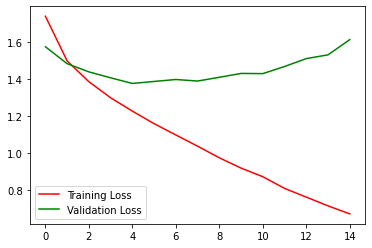

In [ ]:
train_cifar10(vanilla_model_cifar10)

**Training dictinct_source_skip_1_model_cifar10**

[1,   500] loss: 1.682
Epoch 1 training loss = 1.65 validation loss: 1.52
[2,   500] loss: 1.431
Epoch 2 training loss = 1.43 validation loss: 1.45
[3,   500] loss: 1.323
Epoch 3 training loss = 1.32 validation loss: 1.41
[4,   500] loss: 1.229
Epoch 4 training loss = 1.23 validation loss: 1.38
[5,   500] loss: 1.148
Epoch 5 training loss = 1.16 validation loss: 1.36
[6,   500] loss: 1.082
Epoch 6 training loss = 1.08 validation loss: 1.35
[7,   500] loss: 1.008
Epoch 7 training loss = 1.01 validation loss: 1.39
[8,   500] loss: 0.939
Epoch 8 training loss = 0.95 validation loss: 1.38
[9,   500] loss: 0.871
Epoch 9 training loss = 0.88 validation loss: 1.41
[10,   500] loss: 0.806
Epoch 10 training loss = 0.82 validation loss: 1.45
[11,   500] loss: 0.746
Epoch 11 training loss = 0.76 validation loss: 1.48
[12,   500] loss: 0.682
Epoch 12 training loss = 0.69 validation loss: 1.53
[13,   500] loss: 0.626
Epoch 13 training loss = 0.64 validation loss: 1.57
[14,   500] loss: 0.564
Epoch 

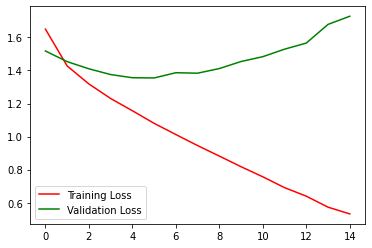

In [ ]:
train_cifar10(dictinct_source_skip_1_model_cifar10)

**Training dictinct_source_skip_2_model_cifar10**

[1,   500] loss: 1.674
Epoch 1 training loss = 1.64 validation loss: 1.53
[2,   500] loss: 1.428
Epoch 2 training loss = 1.43 validation loss: 1.44
[3,   500] loss: 1.312
Epoch 3 training loss = 1.31 validation loss: 1.42
[4,   500] loss: 1.226
Epoch 4 training loss = 1.23 validation loss: 1.38
[5,   500] loss: 1.149
Epoch 5 training loss = 1.15 validation loss: 1.37
[6,   500] loss: 1.067
Epoch 6 training loss = 1.08 validation loss: 1.36
[7,   500] loss: 1.006
Epoch 7 training loss = 1.01 validation loss: 1.38
[8,   500] loss: 0.935
Epoch 8 training loss = 0.94 validation loss: 1.38
[9,   500] loss: 0.866
Epoch 9 training loss = 0.87 validation loss: 1.42
[10,   500] loss: 0.799
Epoch 10 training loss = 0.81 validation loss: 1.45
[11,   500] loss: 0.728
Epoch 11 training loss = 0.74 validation loss: 1.51
[12,   500] loss: 0.661
Epoch 12 training loss = 0.68 validation loss: 1.53
[13,   500] loss: 0.607
Epoch 13 training loss = 0.62 validation loss: 1.58
[14,   500] loss: 0.555
Epoch 

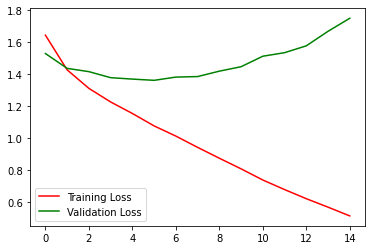

In [ ]:
train_cifar10(dictinct_source_skip_2_model_cifar10)

**Training shared_source_skip_model_cifar10**

[1,   500] loss: 1.835
Epoch 1 training loss = 1.81 validation loss: 1.64
[2,   500] loss: 1.622
Epoch 2 training loss = 1.61 validation loss: 1.65
[3,   500] loss: 1.525
Epoch 3 training loss = 1.52 validation loss: 1.57
[4,   500] loss: 1.439
Epoch 4 training loss = 1.44 validation loss: 1.49
[5,   500] loss: 1.361
Epoch 5 training loss = 1.37 validation loss: 1.49
[6,   500] loss: 1.333
Epoch 6 training loss = 1.33 validation loss: 1.57
[7,   500] loss: 1.273
Epoch 7 training loss = 1.28 validation loss: 1.51
[8,   500] loss: 1.213
Epoch 8 training loss = 1.22 validation loss: 1.55
[9,   500] loss: 1.188
Epoch 9 training loss = 1.19 validation loss: 1.49
[10,   500] loss: 1.139
Epoch 10 training loss = 1.14 validation loss: 1.52
[11,   500] loss: 1.093
Epoch 11 training loss = 1.10 validation loss: 1.55
[12,   500] loss: 1.032
Epoch 12 training loss = 1.04 validation loss: 1.56
[13,   500] loss: 0.993
Epoch 13 training loss = 1.00 validation loss: 1.55
[14,   500] loss: 0.944
Epoch 

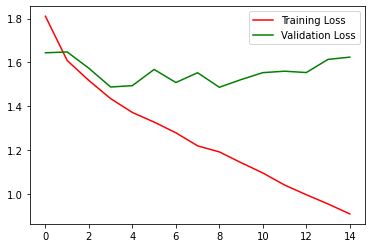

In [ ]:
train_cifar10(shared_source_skip_model_cifar10)

**Training dense_skip_model_cifar10**

[1,   500] loss: 1.812
Epoch 1 training loss = 1.79 validation loss: 1.69
[2,   500] loss: 1.571
Epoch 2 training loss = 1.56 validation loss: 1.52
[3,   500] loss: 1.450
Epoch 3 training loss = 1.45 validation loss: 1.62
[4,   500] loss: 1.363
Epoch 4 training loss = 1.37 validation loss: 1.51
[5,   500] loss: 1.297
Epoch 5 training loss = 1.29 validation loss: 1.49
[6,   500] loss: 1.223
Epoch 6 training loss = 1.23 validation loss: 1.51
[7,   500] loss: 1.142
Epoch 7 training loss = 1.15 validation loss: 1.48
[8,   500] loss: 1.082
Epoch 8 training loss = 1.09 validation loss: 1.46
[9,   500] loss: 1.031
Epoch 9 training loss = 1.04 validation loss: 1.47
[10,   500] loss: 0.954
Epoch 10 training loss = 0.96 validation loss: 1.51
[11,   500] loss: 0.892
Epoch 11 training loss = 0.91 validation loss: 1.66
[12,   500] loss: 0.837
Epoch 12 training loss = 0.84 validation loss: 1.71
[13,   500] loss: 0.786
Epoch 13 training loss = 0.79 validation loss: 1.73
[14,   500] loss: 0.707
Epoch 

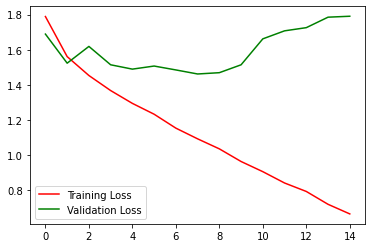

In [ ]:
train_cifar10(dense_skip_model_cifar10)

##**Testing the Models**

**Defining the Test Function**

In [ ]:
def test_cifar10(model):
  model.eval()

  total = 0
  correct = 0
  val_loss = 0.0
  val_steps = 0
  for inputs, labels in testloader_cifar10:
    with torch.no_grad():
      if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_steps += 1
  print("Accuracy = ", correct/total)

**Testing vanilla_model_cifar10**

In [ ]:
test_cifar10(vanilla_model_cifar10)

Accuracy =  0.544


**Testing dictinct_source_skip_1_model_cifar10**

In [ ]:
test_cifar10(dictinct_source_skip_1_model_cifar10)

Accuracy =  0.546


**Testing dictinct_source_skip_2_model_cifar10**

In [ ]:
test_cifar10(dictinct_source_skip_2_model_cifar10)

Accuracy =  0.5461


**Testing shared_source_skip_model_cifar10**

In [ ]:
test_cifar10(shared_source_skip_model_cifar10)

Accuracy =  0.5057


**Testing dense_skip_model_cifar10**

In [ ]:
test_cifar10(dense_skip_model_cifar10)

Accuracy =  0.5257


##**Interpreting the Results on CIFAR 10**

Similar to what we observed on the MNIST dataset, there isn't any significant increase in the performance of the MLP with skip connections in place. Rather, it seems that skip connections when used along the templates of dense and shared skip nets, worsen the performance of the neural network. The up-side to using distinct-source skip connections also doesn't seem very tempting.

Thus, the results seen here again lead us to believe that skip connections do not help further the performance of shallow MLPs on image classification tasks (atleast).


#**Final Results**

**TASKS 1 & 2** : The performance of MLPs with and without skip connections seem similar with not a lot to separate the two. Not only the accuracies, but also the rate of convergence seem alike. Here, are the results observed on the MNIST and CIFAR10 datasets:



1.   MNIST :

      a. Without skip connections (vanilla net) - **98.14%**

      b. Distinct-source skip connections (1 layer skipped) - **98%**

      c. Distinct-source skip connections (2 layers skipped) - **98.03%**
      
      d. Shared-source skip connections - **97.79%**

      e. Dense skip connections - **97.78%**


2.   CIFAR-10 :

      a. Without skip connections (vanilla net) - **54.4%**

      b. Distinct-source skip connections (1 layer skipped) - **54.6%**

      c. Distinct-source skip connections (2 layers skipped) - **54.61%**
      
      d. Shared-source skip connections - **50.57%**

      e. Dense skip connections - **52.57%**


**TASK 3 :** We examined 4 different skip connection networks. In the distinct-source skip connection networks we looked at the results with 1 and 2 layers skipped. The results indicate that a 2 layer skip connection would slightly outperform a single layer skip connection, but nothing too signifcant to come to a conclusion.

Shared-source and dense skip connection networks tend to yield results inferior to the other two skip connection nets examined on the MNIST and CIFAR-10 datasets using MLP models.


**TASK 4 (Bonus) :** Skip connections are known to allow gradients to flow through a network directly, without passing through non-linear activation functions. Non-linear activation functions, by nature of being non-linear, cause the gradients to explode or vanish (depending on the weights). Especially non-linearities like ReLU which make the gradient 0 if the input is negative, which makes it hard for the model to backpropagate the loss to the early-layers of the model. Thus, skip connections allow us to create extremely deep neural networks without worrying about the problem of vanishing and exploding gradients. 

However, since in our assignment we dealt with moderately deep MLPs (5 and 6 layer deep models), the effect of skip connections seems inapprarent. Instead, using skip connections like shared-source and dense skip connections, the performance seems to worsen. Probably because so many skip connections seem to confuse the network in establishing relations among the activations of the intermediate layers.